# Figure 5. Time mean thermodynamic and circulation regime

[Skip code and jump to the figure](#Show-the-figure)

In [1]:
import warnings

warnings.filterwarnings("ignore")
from dataclasses import dataclass, field
from typing import Optional

import cmocean
import iris
import matplotlib.colors as mcol
import matplotlib.pyplot as plt
import numpy as np
from aeolus.calc import calc_derived_cubes, zonal_mean
from aeolus.coord import ensure_bounds
from aeolus.io import load_data
from aeolus.model import lfric
from aeolus.plot import (
    add_custom_legend,
    all_sim_file_label,
    capitalise,
    cube_minmeanmax_str,
    figsave,
    linspace_pm1,
    subplot_label_generator,
    tex2cf_units,
)
from matplotlib.offsetbox import AnchoredText

Local modules

In [2]:
import paths
from common import CONST, DAYSIDE, DC, N_RES, SIMULATIONS

Show all simulations

In [3]:
show_sim = [*SIMULATIONS.keys()]

## Load regridded time-mean data

In [4]:
# Combine two datasets into one cube list
dset = {}
for sim_label in show_sim:
    dset_averages = dset[sim_label] = load_data(
        paths.data_proc
        / SIMULATIONS[sim_label].work_name
        / f"{SIMULATIONS[sim_label].work_name}_averages_*_time_mean_and_regr_{N_RES}.nc".lower()
    )
    dset_inst_diag = load_data(
        paths.data_proc
        / SIMULATIONS[sim_label].work_name
        / f"{SIMULATIONS[sim_label].work_name}_inst_diag_*_time_mean_and_regr_{N_RES}.nc".lower()
    )
    dset_averages = iris.cube.CubeList(
        cube
        for cube in dset_averages
        if cube.var_name
        not in [
            "tot_col_w_kinetic_energy",
            "tot_col_uv_kinetic_energy",
            "cell_area",
        ]
    )
    dset[sim_label] = dset_averages + dset_inst_diag
    calc_derived_cubes(dset[sim_label], const=CONST, model=lfric)

## Make plots

Define coordinate points and labels

In [5]:
lons = dset[sim_label].extract(DC.relax.x)[0].coord(lfric.x).points
lats = dset[sim_label].extract(DC.relax.y)[0].coord(lfric.y).points
heights = dset[sim_label].extract(DC.relax.z)[0].coord(lfric.z).points

coord_mappings = {
    "longitude": dict(ticks=np.arange(-180, 181, 60), units="degrees"),
    "latitude": dict(ticks=np.arange(-90, 91, 30), units="degrees"),
    "level_height": dict(ticks=np.arange(0, 41, 5), units="km"),
}

Define diagnostics

In [6]:
@dataclass
class Diag:
    recipe: callable
    title: str
    units: str
    fmt: str
    kw_plt: dict = field(default_factory=dict)
    method: str = "contourf"


prec_levels = [0.1, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 64]
prec_colors = cmocean.cm.rain(np.linspace(0, 1, len(prec_levels) - 1))
prec_cmap, prec_norm = mcol.from_levels_and_colors(prec_levels, prec_colors)


DIAGS = {
    "t_sfc": Diag(
        recipe=lambda cl: cl.extract_cube(lfric.t_sfc),
        title="Surface Temperature",
        units="$K$",
        method="pcolormesh",
        kw_plt=dict(
            cmap=cmocean.cm.thermal,
            vmin=180,
            vmax=290,
            rasterized=True,
        ),
        fmt="auto",
    ),
    "toa_olr": Diag(
        recipe=lambda cl: cl.extract_cube(lfric.toa_olr),
        title="TOA Outgoing Longwave Radiation",
        units="$W$ $m^{-2}$",
        method="pcolormesh",
        kw_plt=dict(
            cmap=cmocean.cm.gray,
            # levels=np.arange(180, 291, 10),
            vmin=90,
            vmax=240,
            # extend="both",
            rasterized=True,
        ),
        fmt="auto",
    ),
    "u_zm": Diag(
        recipe=lambda cl: zonal_mean(cl.extract_cube(lfric.u)),
        title="Eastward Wind",
        units="$m$ $s^{-1}$",
        method="contourf",
        kw_plt=dict(
            # cmap=swiftascmaps.nineteen_eighty_nine_tv_r,
            # levels=np.arange(-50, 51, 10),
            # extend="both",
            norm=mcol.CenteredNorm(0, halfrange=50),
            cmap=plt.cm.PuOr_r,
            extend="max",
        ),
        fmt="auto",
    ),
    "w_zm_day": Diag(
        recipe=lambda cl: zonal_mean(
            cl.extract_cube(lfric.w).extract(DAYSIDE.constraint)
        ),
        title="Upward Wind, Day Side",
        units="$cm$ $s^{-1}$",
        method="contourf",
        kw_plt=dict(
            # cmap=swiftascmaps.nineteen_eighty_nine_tv_r,
            # levels=linspace_pm1(4) * 2,
            # extend="both",
            levels=linspace_pm1(4) * 2,
            cmap=plt.cm.seismic,
        ),
        fmt="auto",
    ),
}

Assemble the figure using selected diagnostics

In [7]:
diag_keys = ["t_sfc", "toa_olr", "u_zm"]


plot_winds = ["t_sfc"]
height_constraint = iris.Constraint(**{lfric.z: 8000})
plot_w_zm_day = ["u_zm"]

fig = plt.figure(figsize=(8, 1.5 * len(diag_keys)), layout="constrained")
subfigs = fig.subfigures(nrows=len(diag_keys), ncols=1, squeeze=False)[:, 0]
mosaic = [show_sim + ["cax"]]

iletters = subplot_label_generator()
for diag_key, subfig in zip(diag_keys, subfigs):
    axd = subfig.subplot_mosaic(
        mosaic,
        width_ratios=[1] * len(show_sim) + [0.05],
        gridspec_kw={},
    )
    for sim_label in show_sim:
        ax = axd[sim_label]

        ax.set_title(
            f"({next(iletters)})",
            loc="left",
            fontdict={"weight": "bold"},
            pad=3,
        )
        ax.set_title(
            SIMULATIONS[sim_label].title,
            loc="center",
            fontdict={"weight": "bold"},
            pad=3,
            color=SIMULATIONS[sim_label].kw_plt["color"],
        )
        if diag_key == "conv_prec" and sim_label == "hab1_mod_c192s10e":
            [ax.spines[spine].set_visible(False) for spine in ax.spines]
            ax.tick_params(colors=plt.rcParams["figure.facecolor"])
            # ax.
            continue
        cube = DIAGS[diag_key].recipe(dset[sim_label])
        cube.convert_units(tex2cf_units(DIAGS[diag_key].units))
        y, x = cube.dim_coords
        if coord_mapping := coord_mappings.get(x.name()):
            x.convert_units(coord_mapping["units"])
            ax.set_xticks(coord_mapping["ticks"])
            ax.set_xlim(coord_mapping["ticks"][0], coord_mapping["ticks"][-1])
        if coord_mapping := coord_mappings.get(y.name()):
            y.convert_units(coord_mapping["units"])
            ax.set_yticks(coord_mapping["ticks"])
            ax.set_ylim(coord_mapping["ticks"][0], coord_mapping["ticks"][-1])
        if ax.get_subplotspec().is_first_col():
            ax.set_ylabel(
                f"{capitalise(y.name())} [{y.units}]", size="small", labelpad=1
            )
        elif not ax.get_subplotspec().is_last_col():
            ax.set_yticklabels([])
        if ax.get_subplotspec().is_last_row():
            ax.set_xlabel(
                f"{capitalise(x.name())} [{x.units}]", size="small", labelpad=1
            )
        ax.tick_params(labelsize="small")
        h = getattr(ax, DIAGS[diag_key].method)(
            x.points, y.points, cube.data, **DIAGS[diag_key].kw_plt
        )
        if (
            iris.util.guess_coord_axis(x) == "X"
            and iris.util.guess_coord_axis(y) == "Y"
        ):
            at = AnchoredText(
                cube_minmeanmax_str(
                    cube,
                    fmt=DIAGS[diag_key].fmt,
                    precision=1,
                    sep="\n",
                    eq_sign=": ",
                ),
                loc="lower left",
                frameon=True,
                prop={
                    "size": "xx-small",
                    "weight": "bold",
                    "color": SIMULATIONS[sim_label].kw_plt["color"],
                },
            )
            at.patch.set_facecolor(mcol.to_rgba("w", alpha=0.75))
            at.patch.set_edgecolor("none")
            ax.add_artist(at)
        if diag_key in plot_winds:
            u = dset[sim_label].extract_cube(lfric.u)
            v = dset[sim_label].extract_cube(lfric.v)
            for cube in [u, v]:
                ensure_bounds(cube, coords=("z"), model=lfric)
            u = u.extract(height_constraint)
            v = v.extract(height_constraint)
            rounded_height = round(u.coord(lfric.z).points[0])

            wspd = (u**2 + v**2) ** 0.5
            ax.streamplot(
                x.points,
                y.points,
                u.data,
                v.data,
                density=0.75,
                color=SIMULATIONS[sim_label].kw_plt["color"],
                linewidth=wspd.data / wspd.data.max(),
                arrowstyle="Fancy, head_length=0.5, head_width=0.2, tail_width=0.1",
                # broken_streamlines=False
            )
        if diag_key in plot_w_zm_day:
            cube = DIAGS["w_zm_day"].recipe(dset[sim_label])
            cube.convert_units(tex2cf_units(DIAGS["w_zm_day"].units))
            _ = ax.contourf(
                x.points, y.points, cube.data, **DIAGS["w_zm_day"].kw_plt, alpha=0.25
            )
            cntr = ax.contour(x.points, y.points, cube.data, **DIAGS["w_zm_day"].kw_plt)
            ax.clabel(cntr, fmt="%.1f")
    ttl = f"{DIAGS[diag_key].title} [{DIAGS[diag_key].units}]"
    if diag_key in plot_winds:
        ttl += f" and Wind Streamlines at {rounded_height} m"
        extra_label = f"__wind_{rounded_height:05d}m"
    elif diag_key in plot_w_zm_day:
        ttl += f" and {DIAGS['w_zm_day'].title} [{DIAGS['w_zm_day'].units}]"
        extra_label = "__w_zm_day"
    else:
        extra_label = ""
    subfig.suptitle(ttl, fontweight="bold")
    cbar = subfig.colorbar(h, cax=axd["cax"])
    if diag_key in ["tot_prec", "ls_prec", "conv_prec"]:
        cbar.ax.set_yticks(prec_levels)
        cbar.ax.set_yticklabels([str(i) for i in prec_levels])
plt.close()

# Show the figure

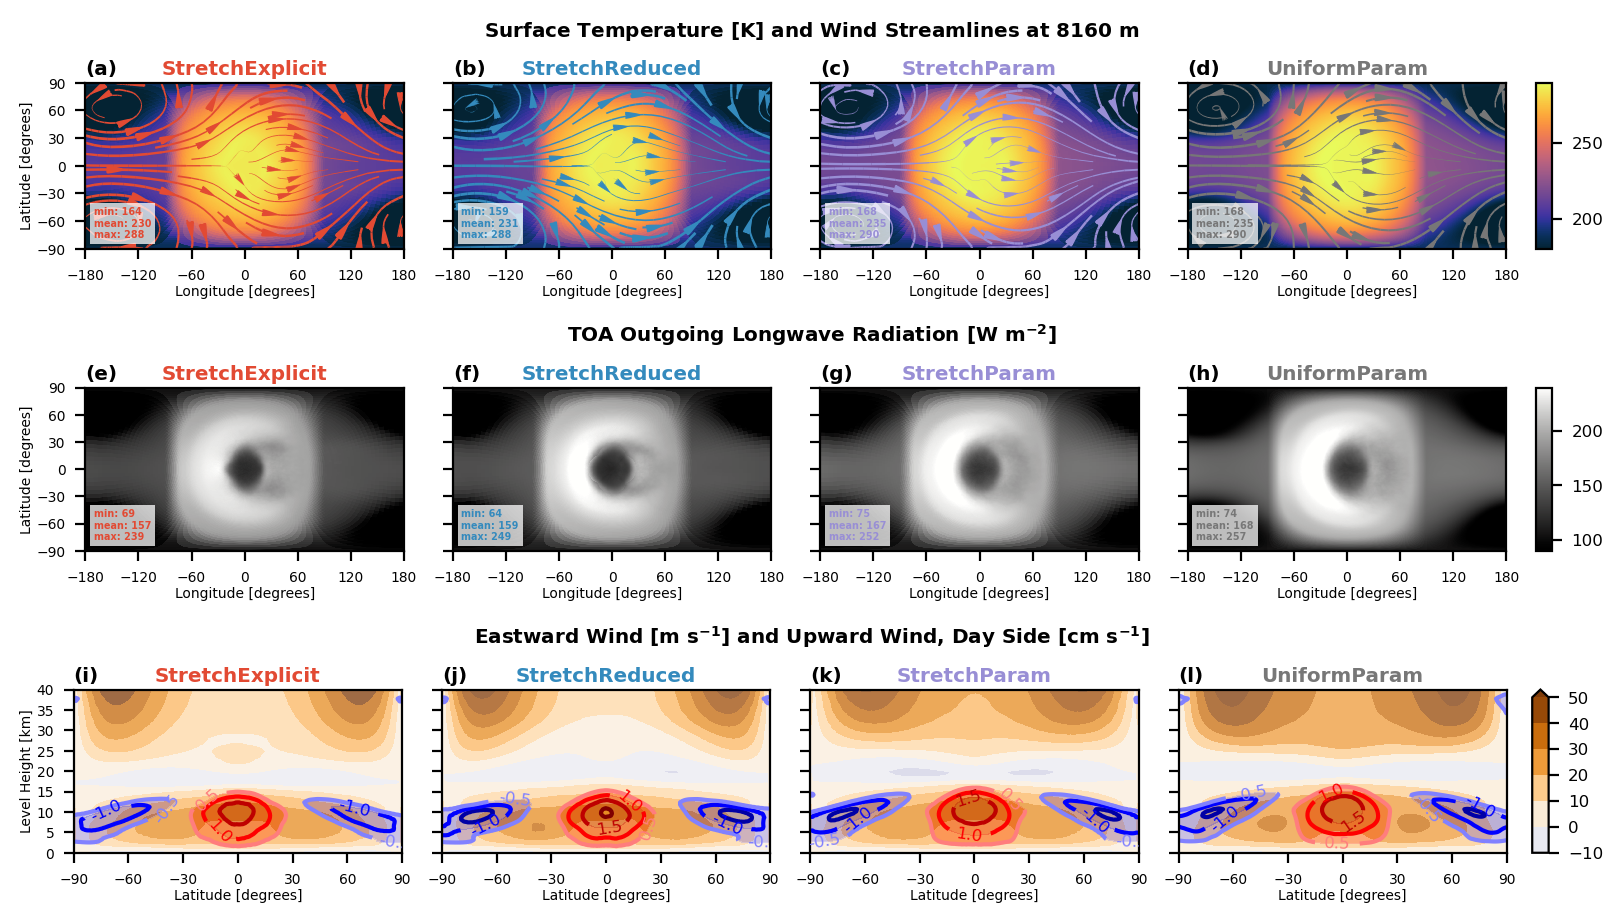

In [8]:
fig

- **Time mean thermodynamic and circulation regime in our simulations.**
- **(a-d) Surface temperature in $K$ overlaid by streamlines of the horizontal wind at $\approx$8 km above the surface.**
- **(e-h) Top-of-atmosphere outgoing longwave radiation in $W$ $m^{-2}$.**
- **(i-l) Zonal mean of the eastward wind (orange contours, m s−1 ) overlaid by the day-side upward wind (red and blue contours, $cm$ $s^{-1}$.**

In [9]:
# and save it
figsave(
    fig,
    paths.figures
    / f"regr__{all_sim_file_label(show_sim)}__{'_'.join(diag_keys)}{extra_label}__tm_map",
)

Saved to ../figures/regr__hab1_mod_c192_s10e_s10r_s10p_p__t_sfc_toa_olr_u_zm__w_zm_day__tm_map.pdf
Size: 1084.1 KB
